# reading The data

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image

%matplotlib inline

In [3]:
root_path = '/kaggle/input/ocr-dataset/OCR_Dates'
files = os.listdir(root_path)
extensions = set()
for file in files:
    extensions.add(file.split('.')[1])

In [4]:
extensions

{'jpg', 'txt'}

In [5]:
print(len(files))

39965


In [6]:
import random

rand = random.choice(files).split('.')[0]
rand

'2165'

In [7]:
with open(f'/kaggle/input/ocr-dataset/OCR_Dates/{rand}.txt', 'r') as f:
    print(f.read())

١٩٦٨/٠٤/٢٥


(500, 80)


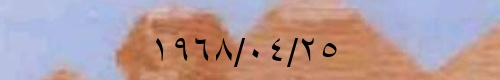

In [8]:
img = Image.open(f'/kaggle/input/ocr-dataset/OCR_Dates/{rand}.jpg')
print(img.size)
img

images shape => (500, 80)

Crop the image on width only by 50%

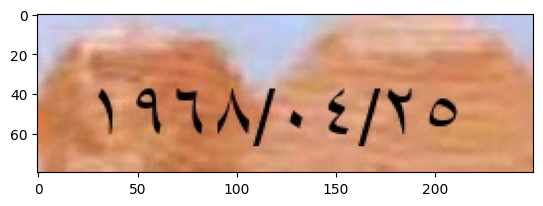

In [9]:
image_path = f'/kaggle/input/ocr-dataset/OCR_Dates/{rand}.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image, channels=3)

image_shape = tf.shape(image)
width_start = image_shape[1] // 4
width_end = 3 * image_shape[1] // 4
cropped_image = tf.slice(image, [0, width_start, 0], [-1, width_end - width_start, -1])

plt.imshow(tf.keras.preprocessing.image.array_to_img(cropped_image))
plt.show()

let's start with the labels  
its obvious that we have
1. output length => 10
2. vocab => (0,1,2,3,4,5,6,7,8,9,/)
3. there is a sequence information in the label

so I will use in the decoder part n LSTM unit with a sequence length of 10 and embedding size of 11

now let's start by building an array of 2 dims the first dim is the image path and the second dim is the label

In [10]:
from genericpath import isfile
import re

ar_to_en = {
    '٠': '0',
    '١': '1',
    '٢': '2',
    '٣': '3',
    '٤': '4',
    '٥': '5',
    '٦': '6',
    '٧': '7',
    '٨': '8',
    '٩': '9',
    '/': '/'
}

data = []
for file in files:
    if re.search(r'.txt$', file):
        path = os.path.join(root_path, file)
        image = os.path.join(root_path, file.split('.')[0]+'.jpg')
        if os.path.isfile(image):
            with open(path, 'r') as f:
                o = f.read()
            o = ''.join([ar_to_en[i] for i in o])
            data.append([image, o.strip()])

In [11]:
data[:10]

[['/kaggle/input/ocr-dataset/OCR_Dates/1893.jpg', '1969/04/02'],
 ['/kaggle/input/ocr-dataset/OCR_Dates/7360.jpg', '1962/10/08'],
 ['/kaggle/input/ocr-dataset/OCR_Dates/1711.jpg', '2023/10/05'],
 ['/kaggle/input/ocr-dataset/OCR_Dates/13052.jpg', '1965/04/02'],
 ['/kaggle/input/ocr-dataset/OCR_Dates/4682.jpg', '2020/12/20'],
 ['/kaggle/input/ocr-dataset/OCR_Dates/5450.jpg', '1998/05/16'],
 ['/kaggle/input/ocr-dataset/OCR_Dates/19963.jpg', '1987/02/03'],
 ['/kaggle/input/ocr-dataset/OCR_Dates/11184.jpg', '1976/07/12'],
 ['/kaggle/input/ocr-dataset/OCR_Dates/11776.jpg', '1974/02/08'],
 ['/kaggle/input/ocr-dataset/OCR_Dates/5064.jpg', '1952/06/01']]

In [13]:
print(len(data))

19980


1991/07/05


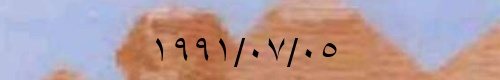

In [14]:
# build a function that take array of img and text to verify
def verify(d):
    print(d[1])
    return Image.open(d[0])

verify(data[20])

# Building the dataset

we will build the dataset as tf.data.Dataset that return a dict with 3 items
1. encoder input
2. decoder input
3. decoder output

for the image i will return its tensor  
for the text i will map each arabic number to its english in trainings and decode back in inference

In [15]:
#first i will create train and test dataset
from sklearn.model_selection import train_test_split

X = [x[0] for x in data]
y = [x[1] for x in data]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=.1, random_state=13)

train_decoder_input = ['G' + label for label in train_y]
train_decoder_output = [label + 'E' for label in train_y]

test_decoder_input = ['G' + label for label in test_y]
test_decoder_output = [label + 'E' for label in test_y]

In [16]:
train_decoder_input[:2], train_decoder_output[:2]

(['G2000/07/11', 'G1990/05/13'], ['2000/07/11E', '1990/05/13E'])

In [17]:
print(f'train length: {len(train_x)}, test length: {len(test_x)}')

train length: 17982, test length: 1998


In [18]:
#hyperparameters

BATCH_SIZE = 4
VOCAB_SIZE = 15
D_MODEL = 128
NUM_HEADS = 1
KEY_DIM = 128

In [51]:
#building  the vectorization layer
from tensorflow.keras.layers import TextVectorization

vocab =['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '/', 'G', 'E']

vect = TextVectorization(standardize=None,
                  split='character',
                  output_sequence_length=11,
                  vocabulary=vocab)

In [52]:
vect.get_vocabulary()

['', '[UNK]', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '/', 'G', 'E']

In [23]:
def preprocess(x, y, z):
    img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(img, channels=3)
    image_shape = tf.shape(img)
    width_start = image_shape[1] // 4
    width_end = 3 * image_shape[1] // 4
    img = tf.slice(img, [0, width_start, 0], [-1, width_end - width_start, -1])
    img = tf.cast(img, tf.float32) / 255.0

    return {'enc_inputs': img, 'dec_inputs': vect(y)}, vect(z)

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_decoder_input, train_decoder_output))\
                  .map(preprocess)\
                  .batch(BATCH_SIZE)\
                  .cache()\
                  .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_decoder_input, test_decoder_output))\
                  .map(preprocess)\
                  .batch(BATCH_SIZE)\
                  .cache()\
                  .prefetch(tf.data.AUTOTUNE)

In [24]:
for i in train_ds.take(1):
    print(i)

({'enc_inputs': <tf.Tensor: shape=(4, 80, 250, 3), dtype=float32, numpy=
array([[[[0.7254902 , 0.73333335, 0.88235295],
         [0.72156864, 0.7294118 , 0.8784314 ],
         [0.70980394, 0.7176471 , 0.8666667 ],
         ...,
         [0.65882355, 0.69411767, 0.80784315],
         [0.6627451 , 0.69803923, 0.8117647 ],
         [0.65882355, 0.7019608 , 0.8117647 ]],

        [[0.72156864, 0.7294118 , 0.8784314 ],
         [0.7176471 , 0.7254902 , 0.8745098 ],
         [0.7137255 , 0.72156864, 0.87058824],
         ...,
         [0.6666667 , 0.7019608 , 0.8156863 ],
         [0.6666667 , 0.7019608 , 0.8156863 ],
         [0.6627451 , 0.7058824 , 0.8156863 ]],

        [[0.7176471 , 0.7254902 , 0.8745098 ],
         [0.7176471 , 0.7254902 , 0.8745098 ],
         [0.7137255 , 0.72156864, 0.87058824],
         ...,
         [0.6666667 , 0.7019608 , 0.8156863 ],
         [0.6666667 , 0.7019608 , 0.8156863 ],
         [0.65882355, 0.7019608 , 0.8117647 ]],

        ...,

        [[0.7372549

# Modeling

for the encoder part i will use Mobilenetv3  
for the decoder i will use lstm  
and i will add multihead attention layer between encoder and decoder

In [25]:
from tensorflow.keras import layers as tfl
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import Model

#encoder
enc_sub_model = MobileNetV3Small(input_shape=(80, 250, 3),
                                 include_top=False,
                                 weights='imagenet')
img_input = tfl.Input(shape=(80, 250, 3), name='enc_inputs')
x = enc_sub_model(img_input)
x = tfl.Reshape((-1, x.shape[-1]))(x)#(batch, (w*h), c)

#decoder
txt_input = tfl.Input(shape=(11), name='dec_inputs')
y = tfl.Embedding(VOCAB_SIZE+1, D_MODEL)(txt_input)
y, _, _ = tfl.LSTM(D_MODEL, return_sequences=True, return_state=True)(y) #(batch, length, emb)

#attention
attn_outs, attn_scrs = tfl.MultiHeadAttention(NUM_HEADS, KEY_DIM)(y, x, x, use_causal_mask=True, return_attention_scores=True)

#output
y = y + attn_outs
y = tfl.Dense(256, activation='relu')(y)
outs = tfl.Dense(VOCAB_SIZE, activation='softmax')(y)

model = Model(inputs=[img_input, txt_input], outputs=outs)
model.summary()

4334752/4334752 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dec_inputs (InputLayer)        [(None, 10)]         0           []                               
                                                                                                  
 enc_inputs (InputLayer)        [(None, 80, 250, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 embedding (Embedding)          (None, 10, 128)      2048        ['dec_inputs[0][0]']             
                                                                                                  
 MobilenetV3small (Functional) 

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit(train_ds, epochs=3, validation_data=test_ds)

Epoch 1/3
4496/4496 [==============================] - 560s 120ms/step - loss: 0.1386 - accuracy: 0.9605 - val_loss: 3.1238 - val_accuracy: 0.2371
Epoch 2/3
4496/4496 [==============================] - 518s 115ms/step - loss: 0.0122 - accuracy: 0.9968 - val_loss: 0.0300 - val_accuracy: 0.9888
Epoch 3/3
4496/4496 [==============================] - 525s 117ms/step - loss: 9.9966e-06 - accuracy: 1.0000 - val_loss: 3.7350e-06 - val_accuracy: 1.0000


# Saving The Model

i will save the model with its dependencies

In [37]:
#save the model as a keras model

path = '/kaggle/working/keras_model/'
model.save(path)

In [85]:
#save the text vectorization layer
import pickle

layer_config = vect.get_config()
layer_vocab = vect.get_vocabulary()

with open('/kaggle/working/vocab.pkl', 'wb') as f:
    pickle.dump({'config': layer_config, 'vocab': layer_vocab}, f)

# Inference Code

In [89]:
#loading the model
path = '/kaggle/working/keras_model/'
my_model = tf.keras.models.load_model(path)

#loading the vocab
with open('/kaggle/working/vocab.pkl', 'rb') as f:
    data = pickle.load(f)
vect_layer = tf.keras.layers.TextVectorization.from_config(data['config'])
vect_layer.set_vocabulary(data['vocab'])

my_model, vect_layer

(<keras.engine.functional.Functional at 0x78e2d30cdb40>,
 <keras.layers.preprocessing.text_vectorization.TextVectorization at 0x78e2d3600f70>)

In [90]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dec_inputs (InputLayer)        [(None, 10)]         0           []                               
                                                                                                  
 enc_inputs (InputLayer)        [(None, 80, 250, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 embedding (Embedding)          (None, 10, 128)      2048        ['dec_inputs[0][0]']             
                                                                                                  
 MobilenetV3small (Functional)  (None, 3, 8, 576)    939120      ['enc_inputs[0][0]']         

In [95]:
def inference(path: str) -> str:
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    image_shape = tf.shape(img)
    width_start = image_shape[1] // 4
    width_end = 3 * image_shape[1] // 4
    img = tf.slice(img, [0, width_start, 0], [-1, width_end - width_start, -1])
    img = tf.cast(img, tf.float32) / 255.0
    
    def date(img):
        img = tf.expand_dims(img, 0)
        tokens = ['G']
        vectorized = vect_layer(''.join(tokens))
        sliced_vectorized = vectorized[:10]
        inputs = tf.expand_dims(sliced_vectorized, 0)
        idx_to_wrd = dict(enumerate(vect.get_vocabulary()))
        
        for i in range(10):
            predictions = my_model([img, inputs])
            idx = np.argmax(predictions[0, i, :])
            wrd = idx_to_wrd[idx]
            if wrd == 'E':
                break
#             print(wrd, end="")
            tokens.append(wrd)
            vectorized = vect_layer(''.join(tokens))
            sliced_vectorized = vectorized[:10]
            inputs = tf.expand_dims(sliced_vectorized, 0)

        return tokens[1:]

    date = date(img)
    en_to_ar = { '0': '٠', '1': '١', '2': '٢', '3': '٣', '4': '٤', '5': '٥', '6': '٦', '7': '٧', '8': '٨', '9': '٩',  '/': '/'}
    
    return ''.join([en_to_ar[i] for i in date])

'١٩٦٩/٠٤/٠٢'

١٩٦٩/٠٤/٠٢


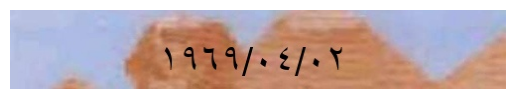

In [121]:
print(inference('/kaggle/input/ocr-dataset/OCR_Dates/1893.jpg'))
img = plt.imread('/kaggle/input/ocr-dataset/OCR_Dates/1893.jpg')
plt.axis('off')
plt.imshow(img)

# Save The Model In Tf_lite for end_point

In [98]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

In [99]:
with open('/kaggle/working/date_extractor.tflite', 'wb') as f:
    f.write(tflite_model)

# Inference Using tf_lite

In [100]:
interpreter = tf.lite.Interpreter('/kaggle/working/date_extractor.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 2 nodes delegated out of 200 nodes with 2 partitions.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [101]:
input_details

[{'name': 'serving_default_dec_inputs:0',
  'index': 0,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([-1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'serving_default_enc_inputs:0',
  'index': 1,
  'shape': array([  1,  80, 250,   3], dtype=int32),
  'shape_signature': array([ -1,  80, 250,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [102]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 359,
  'shape': array([ 1,  1, 15], dtype=int32),
  'shape_signature': array([-1, -1, 15], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [118]:
def tf_lite_inference(path: str) -> str:
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    image_shape = tf.shape(img)
    width_start = image_shape[1] // 4
    width_end = 3 * image_shape[1] // 4
    img = tf.slice(img, [0, width_start, 0], [-1, width_end - width_start, -1])
    img = tf.cast(img, tf.float32) / 255.0
    
    def date(img):
        img = tf.expand_dims(img, 0)
        tokens = ['G']
        vectorized = vect_layer(''.join(tokens))
        sliced_vectorized = vectorized[:10]
        inputs = tf.expand_dims(sliced_vectorized, 0)
        idx_to_wrd = dict(enumerate(vect.get_vocabulary()))
        
        for i in range(10):
            interpreter.set_tensor(input_details[0]['index'], tf.cast(inputs, tf.float32))            
            interpreter.set_tensor(input_details[1]['index'], img)
            interpreter.invoke()
            predictions = interpreter.get_tensor(output_details[0]['index'])
            
            idx = np.argmax(predictions[0, i, :])
            wrd = idx_to_wrd[idx]
            if wrd == 'E':
                break
            tokens.append(wrd)
            vectorized = vect_layer(''.join(tokens))
            sliced_vectorized = vectorized[:10]
            inputs = tf.expand_dims(sliced_vectorized, 0)

        return tokens[1:]

    date = date(img)
    en_to_ar = { '0': '٠', '1': '١', '2': '٢', '3': '٣', '4': '٤', '5': '٥', '6': '٦', '7': '٧', '8': '٨', '9': '٩',  '/': '/'}
    
    return ''.join([en_to_ar[i] for i in date])

٢٠١٠/١١/١١


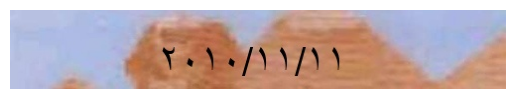

In [120]:
print(tf_lite_inference('/kaggle/input/ocr-dataset/OCR_Dates/1694.jpg'))
img = plt.imread('/kaggle/input/ocr-dataset/OCR_Dates/1694.jpg')
plt.axis('off')
plt.imshow(img)

# Compareing the time difference in tflite and the main model

In [111]:
%timeit tf_lite_inference('/kaggle/input/ocr-dataset/OCR_Dates/1893.jpg')

151 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [117]:
%timeit inference('/kaggle/input/ocr-dataset/OCR_Dates/1893.jpg')

2.01 s ± 32.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Save The Model in ONNX

In [126]:
%pip install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 7.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [128]:
import onnx
import tf2onnx

onnx_model_name = 'date_extractor.onnx'
onnx_model, _ = tf2onnx.convert.from_keras(model)
onnx.save(onnx_model, onnx_model_name)